# Not a Hotdog

Written by Ian McKechnie throughout 2022

## Imports

In [73]:
import torch
import torch.nn as nn
import os
import pandas as pd
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from torchvision.io import read_image
import matplotlib.pyplot as plt
import helper
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler



## Import the image set into a dataloader

In [74]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [85]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder('./archive/train/', transform=transform)
trainLoader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

dataset = datasets.ImageFolder('./archive/test/', transform=transform)
testLoader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
running_loss = 0.0


## Show a few example images

Hotdog


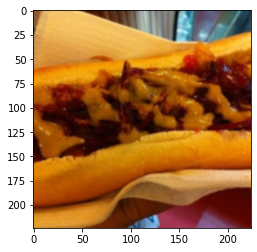

In [108]:
images, labels = next(iter(testLoader))
image = images[0]

if labels[0].long() == 0:
    print("Hotdog")
else:
    print("Not hotdog")

plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic")


## Now to perform the training

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset_sizes = {'train': len(trainLoader.dataset), 'val': len(testLoader.dataset)}

def train_model(Trainloader, testLoader, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        #For the train phase
        phase = 'train'
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in trainLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        #Validation phase
        phase = 'val'
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in testLoader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [90]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [93]:
model_ft = train_model(trainLoader, testLoader, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6518 Acc: 0.6044
val Loss: 0.5008 Acc: 0.7500

Epoch 1/24
----------
train Loss: 0.3734 Acc: 0.8494
val Loss: 0.3522 Acc: 0.8420

Epoch 2/24
----------
train Loss: 0.2360 Acc: 0.9337
val Loss: 0.3234 Acc: 0.8660

Epoch 3/24
----------
train Loss: 0.1318 Acc: 0.9859
val Loss: 0.2732 Acc: 0.8740

Epoch 4/24
----------
train Loss: 0.0933 Acc: 0.9940
val Loss: 0.2668 Acc: 0.8820

Epoch 5/24
----------
train Loss: 0.0821 Acc: 0.9900
val Loss: 0.2623 Acc: 0.8840

Epoch 6/24
----------
train Loss: 0.0469 Acc: 0.9980
val Loss: 0.2599 Acc: 0.8860

Epoch 7/24
----------
train Loss: 0.0369 Acc: 1.0000
val Loss: 0.2555 Acc: 0.8860

Epoch 8/24
----------
train Loss: 0.0473 Acc: 0.9880
val Loss: 0.2560 Acc: 0.8860

Epoch 9/24
----------
train Loss: 0.0316 Acc: 1.0000
val Loss: 0.2588 Acc: 0.8800

Epoch 10/24
----------
train Loss: 0.0492 Acc: 0.9980
val Loss: 0.2588 Acc: 0.8860

Epoch 11/24
----------
train Loss: 0.0407 Acc: 1.0000
val Loss: 0.2610 Acc: 0.8760

Ep

## Showing some example images and their predictions

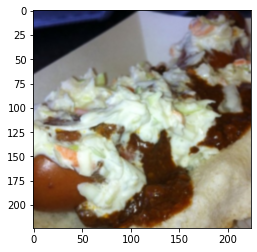

label =  0
This is an image of a Hotdog
It's predicted to be a hotdog
The prediction is correct



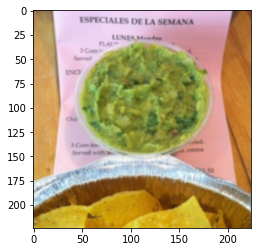

label =  1
This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



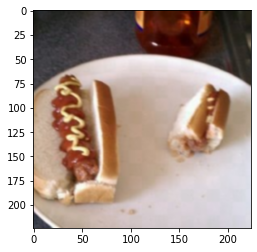

label =  0
This is an image of a Hotdog
It's predicted to be a hotdog
The prediction is correct



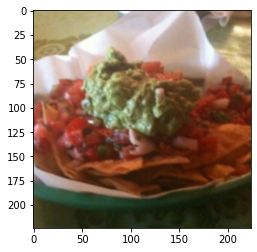

label =  1
This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



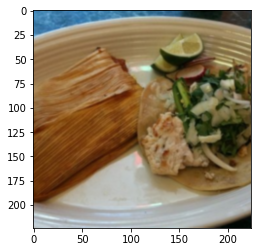

label =  1
This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



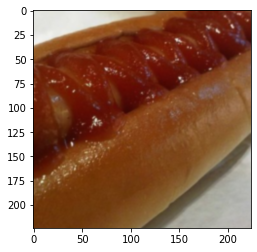

label =  0
This is an image of a Hotdog
It's predicted to be a hotdog
The prediction is correct



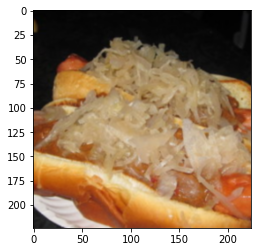

label =  0
This is an image of a Hotdog
It's predicted to be a hotdog
The prediction is correct



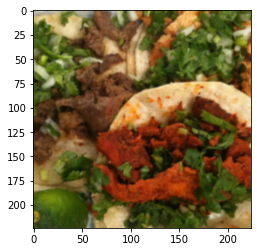

label =  1
This image is not a hotdog
The image is predicted to be NOT a hotdog
The prediction is correct



In [116]:
images, labels = next(iter(testLoader))

for i in range(8):
    image = images[i]
    label = labels[i]   
    plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic")
    plt.show()

    print("label = ", labels[i].long().item())

    if labels[i].long().item() == 0:
        print("This is an image of a Hotdog")
    else:
        print("This image is not a hotdog")

    outputs = model_ft(image.unsqueeze(0).to(device))
    _, preds = torch.max(outputs, 1)
    if preds[0].long() == 0:
        print("It's predicted to be a hotdog")
    else:
        print("The image is predicted to be NOT a hotdog")

    if labels[i].long().item() == preds[0].long():
        print("The prediction is correct")
    else:
        print("The prediction is wrong")
    print()